In [1]:
import re
from os import path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

id  \
516489  1160699524102447105   
128272  1559865624599437312   
390402  1160219119888867329   
301211  1559957765673590786   
111022  1559856342512410625   
288182  1559952598467334145   
514709  1160698502978125831   
830575  1161230350439202821   
454109  1160597115615232011   
229319  1559909516275339268   

                                                     text     score  label  
516489        meu sonho é casar com essa grt ! 👩‍❤️‍👩🤤🤤❤️  1.492174      1  
128272   vamos visitar o iml&gt;&gt;&gt; 💕💖💞💗💓 finalmente  3.419561      1  
390402  tinha associado a texto da glória perez saindo...  0.456039      1  
301211                                  morta ma felice 💞  0.742358      1  
111022                                  obrigado leo ❤️❤️  1.492174      1  
288182                       eu venci, obg papai do céu 💞  0.742358      1  
514709                            amiga esse é o melhor 😍  0.677937      1  
830575  meus amores, bom dia, olha que vitória.💕 (prév...  0.632917      1  
454109                         qnd eu for pro pc eu add 💙  0.732456      1  
229319  oi lett achei que ninguém ia me responder 😭 tô... -0.093377     -1

## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

183      teus
128     nosso
172    tenham
31      entre
139     pelos
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: a caminho ✈

Tweet Limpo   : caminho

Tweet Stemed  : caminh


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

id                                              text  \
181623  1559890561099866112                             ruinzinho? q isso 😂😂😂   
23511   1559748565437763585                   meu deus tadinho 😫😫😫 que horror   
107727  1559854424754987008  está valendo tb, o importante é se movimentar. 😊   
398713  1160303728731336705                                    boa tricolor 👍   
681456  1160928289596289025                                   top ngameu 😂 dm   

           score  label                 cleaned  
181623  0.662905      1                  ruin q  
23511  -0.436831     -1            deu tad horr  
107727  0.644696      1  val tb import moviment  
398713  0.522114      1              boa tricol  
681456  0.220968      0             top ngam dm

# Engenharia de Atributos: TF-IDF Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(X_train["cleaned"])

TfidfVectorizer(ngram_range=(1, 2))

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Seleção de Atributos

Referência:

- [https://en.wikipedia.org/wiki/Feature_selection](https://en.wikipedia.org/wiki/Feature_selection)
- [https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [14]:
selector = SelectPercentile(f_classif, percentile=60)

selector.fit(X_features_train, y_features_train)

SelectPercentile(percentile=60)

In [15]:
X_features_train_selected = selector.transform(X_features_train)
X_features_test_selected = selector.transform(X_features_test)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [16]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train_selected)

StandardScaler(with_mean=False)

In [17]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train_selected)

In [18]:
X_features_test_scaled = scaler.transform(X_features_test_selected)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [19]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 8.41%


In [20]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 14.25%


In [21]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 24.57%


In [22]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 24.57%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [23]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [24]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(
    nb, params, n_iter=10, scoring="f1_macro", n_jobs=-1, random_state=42
)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 53.99%


In [25]:
clf.best_params_

{'alpha': 1.394736842105263}

In [26]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [27]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 24.57%
Score Modelo   : 53.99%
Diferença      : 29.42%


### Performance no Conjunto de Treino

In [28]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 86.62%


### Curva de Aprendizado

In [29]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

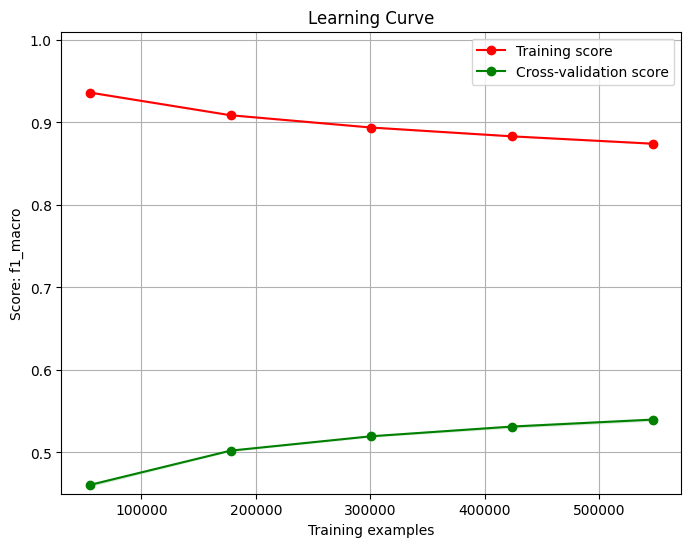

In [30]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [31]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 49.11%


### Preditos Positivos

In [32]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [33]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['agladimmm esas sensem mukemmel 😭🫂',
       'nunca imaginei que viveria de marmita. 🤫 kkk isso que dá querer ter vida fitnes. 😩',
       'sabia nada👎', 'eu tatuada seria incrível 😞',
       'a playlist que vc me mandou é simplesmente perfeita, desculpe pela minha reação escandalosa 😔',
       'sedenta pra fumar um baseado 😫',
       'saudade do meu namorado, boa noite 😔',
       'alguém me indica um lugar p trocar tela de celular q não seja tão caro 😩',
       'no podemos brishar 😒',
       'q ódio não tenho mais meus vídeos dançando 😫'], dtype=object)

#### Falso Positivo -> Neutro

In [34]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['nunca tinha visto e o yuta e o johnny nessa apresentação 😳',
       'então 😂',
       'kamily mandou me chamar no microfone aquela vadia kkk todo mundo falando que ouviu 😂',
       'é isso aí👊🇧🇷', 'ainda bem que sou estilosa 😮\u200d💨😂',
       'tão perseguindo o camisa deles lá igual a gente faz aqui em são januário 😅',
       'eu também 😂',
       'ques testar minha paciência ? vais ver como eu to paciente então 💥',
       'com toda sinceridade, meus parabéns , esse vídeo ficou incrível 💯',
       'quando não né 😂'], dtype=object)

#### Verdadeiro Positivo

In [35]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['amém! bom dia menina nina. que a paz e a felicidade seja nossa companheira em nosso dia a dia! 🙏🙏☕☕❤❤',
       'rogéria e ana cristina. não sabia? 😁', 'linda 💕',
       'tudo é no tempo de deus ,na hora certa tudo se ajeita 🙏',
       '• por enquanto, acho que é só. obrigada pela atenção e espero que gostem. ♡',
       'lindooo ❤', 'que linda sua tatto 💜', 'txii cozinho muitooo! 😋',
       'amanheceu, nada pesquei 🎶', 'paz para os ouvidos 😎'], dtype=object)

### Preditos Negativos

In [36]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [37]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['perfeita senhorr 😍',
       'bom dia! passando pra lembrar que não respondo “oi” na dm 😉',
       'meu bom dia vai de ferit aslan, pois e meu favorito 😍',
       'me ensina mais que professores poderiam ensinar.! 💚',
       'aff amanhã começa tudo de novo dieta, facu deus olha por mim 🙌',
       'tu é tão linda 😊 — teu conceito de bonito anda bem baixo hein',
       'brincadeira não tenho nada a esconder 😘',
       'estamos tão longe, niño. é uma pena 😋',
       'parece bizarro mas hoje estou com aquela velha sensação de que vou morrer morrer cedo... pronta estou, mas espero ter a chance de conhecer minhas meninas 💛',
       'estou tão mal e eu odeio ficar assim logo na escola👌'],
      dtype=object)

#### Falso Negativo -> Neutro

In [38]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['mil resolve minha vida 😂', 'eu pensei que eras amigável afinal 👀',
       'eu boto as perna assim pra sentar. pensava que era normal 😂',
       'pelo amor de deus todos onibus que eu peguei hoje atrasaram, eu só queria me alimentar 😥',
       'já sabes, só não queria acampar no sudas por causa das aranhas 😳',
       'virou 😇 anjinho o filhote do diabo 👹 🤭😅',
       'engordando junto com o bolso 😅', 'ai meu deus do ceu q comédia 😂',
       'achaaa😂',
       'eu morro mas não faço merda no meu cabelo, obrigada pelo bom gosto deus, pq eu só penso no trabalho pra consertar 😂'],
      dtype=object)

#### Verdadeiro Negativo

In [39]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['bom dia, quase boa tarde. putz essa vacina derruba igual a terceira. muita febre e dores horríveis. só quero ficar em posição fetal 😭',
       'não aguento mais ficar em casa, já até emagreci, preciso ocupar minha mente. preciso de um empregooo 😫',
       'essas pompas são ridículas. eles são pessoas como outras pessoas. pra que tapete?😡',
       'caramba quem inventou o ciúmes 😠', 'sim pena q é rival😔',
       'sdd de trabalhar com ela aqui do meu ladinho 🖤💔',
       'o jooyeon tava tão felizinho eu quero chorar 😭',
       'estava procurando um negócio do jooheon e... 😫 acho melhor ir dormir',
       'nó bateu maior bad aki 😔',
       'quanto mais eu quero que a hora passe ela demora 😡'], dtype=object)

### Preditos Neutros

In [40]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [41]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['goiabada com creme de leite 🙏', 'pele de galinha 😜',
       'sabe ler? "a unica arabia que eu conheço e na mangueirinha" tua opiniao p mim nao ta mudando em nd. continuo n conhecendo 😘',
       'falei ctg no open haha, msm que foi minutinho, tu é muito doce 😊 — etcha lele. muito obrigada hahaahha',
       'pila cada xícara 😝😂', 'não vai sobrar ngm vivo 🔥🔥',
       'consegui resolver minhas coisas que estavam pendentes, me sentindo até um pouco mais aliviada.🙌',
       'minhas entradas para hoje! 📍champions odd . 📍brazilian cup odd . dependendo dos resultados vou fazer algo na mls ainda, fé! 🙏💰✅',
       'hehehehhehehe tá foda kkk 🙈 nego mal criado',
       'o ex-diretor do inpe defendendo a ciência brasileira nessa mesa de discussão é tudo pra mim. 😍'],
      dtype=object)

#### Falso Neutro -> Negativo

In [42]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['kkk rindo de desespero, infelizmente 😫',
       'menstruação pra q judiar tanto 😩',
       'virginia no meio dos pobres 😩', 'a lauren passou e eu nem vi 😔',
       'sou de campinas, se eu tivesse como ir pra indaiatuba eu ate ia com vc mo 😔',
       'estou num tédio danado hoje e não tem nada pra fazer 😴',
       'não me toca, estou sensível 😞',
       'a falta que a andressa vai fazer é enorme 😞',
       'porque móveis planejados tem que ser tão caros? 💔',
       'final de domingo e aqui a preguiça reina 😴'], dtype=object)

#### Verdadeiro Neutro

In [43]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['kevin da graça do vale rosa monteiro carreira cerejo ( gostava de ter a parte da graça 😥 )',
       'só troca a cerveja galera lkkk brahma da dor de cabeça 😂',
       'não estás biz desabafar? 😂',
       'um dia destes tiro foto do meu braço ao lado do do meu pai! 😅',
       'pra vcs em sp tá uma maravilha! já aqui no rio a coisa tá estranha... gov vai ser o cláudio castro mesmo, pq os outros andam prometendo até terreno na em marte😅',
       'e como está a suas viagens com aquelas dormidas acordado? 😂',
       'triste quando vc responde todo dia a pessoa, e no fim parace que ela tá cagando pra vc 😥',
       'não vou nem perguntar se tá, porque eu sei que tá! 😂', 'no vex😂',
       'nem eu sei que te diga e nem é comigo 😂'], dtype=object)